# 한글 Word2Vec 만들기

In [2]:
!pip install konlpy > /dev/null

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep='\t')
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 데이터 전처리

In [5]:
# 중복 여부 확인
df.shape, df.document.nunique()

((200000, 3), 194543)

In [8]:
# 중복 데이터 배제|
df.drop_duplicates(subset=['document'], inplace=True)
df.shape

(194544, 3)

In [10]:
# Null 데이터가 있는지 확인
df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [11]:
# Null 데이터 제거
df.dropna(how='any', inplace=True)
df.shape

(194543, 3)

In [12]:
# 한글과 공백 이외는 제거
df['document'] = df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [14]:
import numpy as np
df['document'].replace('', np.nan, inplace=True)
df.document.isnull().sum()

491

In [15]:
df.dropna(how='any', inplace=True)
df.shape

(194052, 3)

- 불용어 사전 활용하여 불용어 처리

In [16]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving 한국어불용어100.txt to 한국어불용어100.txt


In [17]:
sdf = pd.read_csv(filename, sep='\s+', header=None)
sdf.head()

,0,1,2
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [18]:
# 품사를 무시하고 중복 배제
stopwords = set(sdf[0])
len(stopwords)

94

In [ ]:
print(stopwords)

In [26]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 한글 형태소 분석

In [19]:
okt = Okt()

In [27]:
from tqdm.notebook import tqdm
tokenized_data = []
for sentence in tqdm(df.document):
  morphs = okt.morphs(sentence.strip(), stem=True)
  temp_list = [word for word in morphs if word not in stopwords]
  tokenized_data.append(temp_list)

  0%|          | 0/194052 [00:00<?, ?it/s]

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.996325727124688


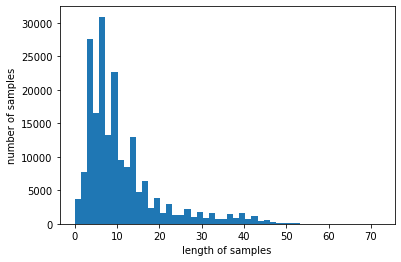

In [28]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
len(tokenized_data)

194052

## Word2Vec 훈련시키기
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

In [30]:
from gensim.models import Word2Vec
%time model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)

CPU times: user 32.7 s, sys: 197 ms, total: 32.9 s
Wall time: 19.3 s


In [31]:
model.wv.vectors.shape

(16466, 100)

In [34]:
model.wv.most_similar("최민식")

[('이민호', 0.8642534017562866),
 ('안성기', 0.861640214920044),
 ('김명민', 0.8518854379653931),
 ('한석규', 0.8460501432418823),
 ('베일', 0.8447542190551758),
 ('크리스찬', 0.8406051397323608),
 ('유다인', 0.8396936655044556),
 ('김창완', 0.8389281034469604),
 ('김수현', 0.8299893140792847),
 ('채민서', 0.823265790939331)]

In [35]:
model.wv.most_similar("히어로")

[('느와르', 0.8757073283195496),
 ('무협', 0.863317608833313),
 ('슬래셔', 0.8609129190444946),
 ('블록버스터', 0.835304856300354),
 ('헐리우드', 0.8235099911689758),
 ('호러', 0.8199030160903931),
 ('물', 0.8145691156387329),
 ('물의', 0.8084035515785217),
 ('정통', 0.8061551451683044),
 ('홍콩', 0.7989487051963806)]